In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import cv2
import h5py
import pandas as pd
import scanpy as sc 
from os.path import join as j_
import os
import ipdb
import openslide
import numpy as np
from tqdm import tqdm
import torch
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, sampler
from torch_geometric.utils import to_networkx
import networkx as nx

from wsi_datasets import WSIClassificationDataset
from mil_models import SAEConfig, SAE

/home/fywang/miniconda3/envs/spanther/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split_dir = "/home/fywang/Documents/SPANTHER/src/splits/classification/BRCA"
split_names = "train,val,test"

fold_idx = None
splits_csvs = {}
split_names = split_names.split(',')
print(f"Using the following split names: {split_names}")
for split in split_names:
    if fold_idx is not None:
        split_path = j_(split_dir, f'{split}_{fold_idx}.csv')
    else:
        split_path = j_(split_dir, f'{split}.csv')
    
    if os.path.isfile(split_path):
        df = pd.read_csv(split_path)#.sample(frac=1, random_state=0).head(25).reset_index(drop=True)
        assert 'Unnamed: 0' not in df.columns
        splits_csvs[split] = df


Using the following split names: ['train', 'val', 'test']


In [3]:
train_kwargs = dict(data_source=['/data1/r20user2/wsi_data/TCGA_BRCA/extracted_mag20x_patch256/conch_pt_patch_features/h5_files'],
                    label_map={'IDC': 0, 'ILC': 1},
                    target_col='oncotree_code',
                    bag_size=-1,
                    shuffle=True,
                    load_cluster_feats=False
                    )

# use the whole bag at test time
val_kwargs = dict(data_source=['/data1/r20user2/wsi_data/TCGA_BRCA/extracted_mag20x_patch256/conch_pt_patch_features/h5_files'],
                  label_map={'IDC': 0, 'ILC': 1},
                  target_col='oncotree_code',
                  bag_size=-1,
                  load_cluster_feats=False
                  )


In [4]:
def build_sampler(dataset, sampler_type=None):
    data_sampler = None
    if sampler_type is None:
        return data_sampler
    
    assert sampler_type in ['weighted', 'random', 'sequential']
    if sampler_type == 'weighted':
        labels = dataset.get_labels(np.arange(len(dataset)), apply_transform=True)
        uniques, counts = np.unique(labels, return_counts=True)
        weights = {uniques[i]: 1. / counts[i] for i in range(len(uniques))}
        samples_weight = np.array([weights[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        data_sampler = sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    elif sampler_type == 'random':
        data_sampler = sampler.RandomSampler(dataset)
    elif sampler_type == 'sequential':
        data_sampler = sampler.SequentialSampler(dataset)

    return data_sampler

In [5]:
dataset_splits = {}
sampler_types={'train': 'random',
               'val': 'sequential',
               'test': 'sequential'}
batch_size=1
num_workers=2

for k in splits_csvs.keys(): # ['train', 'val', 'test']
    print("\nSPLIT: ", k)
    df = splits_csvs[k]
    dataset_kwargs = train_kwargs.copy() if (k == 'train') else val_kwargs.copy()
    if k == 'test_nlst':
        dataset_kwargs['sample_col'] = 'case_id'
    dataset = WSIClassificationDataset(df, **dataset_kwargs)
    data_sampler = build_sampler(dataset, sampler_type=sampler_types.get(k, 'sequential'))

    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=data_sampler, 
                            num_workers=num_workers, shuffle=False)
    dataset_splits[k] = dataloader
    print(f'split: {k}, n: {len(dataset)}')


SPLIT:  train
oncotree_code
IDC    561
ILC    116
split: train, n: 677

SPLIT:  val
oncotree_code
IDC    63
ILC    13
split: val, n: 76

SPLIT:  test
oncotree_code
IDC    70
ILC    14
split: test, n: 84


In [6]:
# check test set
sae_config = SAEConfig()
sae_config.in_dim = 512
sae = SAE(sae_config)
sae.eval()

ckpt = torch.load("/home/fywang/Documents/SPANTHER/src/results/BRCA_SAE/BRCA_SAE::SAE_default/BRCA_SAE/k=0/BRCA::SAE_default::h5_files/BRCA::SAE_default::h5_files::25-03-05-13-28-26/s_checkpoint.pth")
sae.load_state_dict(ckpt['model'])

/tmp/ipykernel_1933199/130301041.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/home/fywang/Documents/SPANTHER/src/results/BRCA_SAE/BRCA_SAE::SAE_de

<All keys matched successfully>

In [7]:
with torch.no_grad():
    for idx, sample in enumerate(dataset_splits["test"]):
        results_dict, log_dict = sae(sample["img"])
        break

In [8]:
log_dict

{'loss': 0.25441092252731323,
 'rec_loss': 0.0005201761377975345,
 'sparsity_loss': 0.2538907527923584}

In [9]:
results_dict["decoded"]

tensor([[ 0.0141,  0.0518,  0.0330,  ...,  0.0348, -0.0371,  0.0080],
        [-0.0023,  0.0433,  0.0170,  ...,  0.0397, -0.0467, -0.0100],
        [ 0.0157,  0.0384,  0.0374,  ...,  0.0388, -0.0512, -0.0215],
        ...,
        [ 0.0064,  0.0477,  0.0150,  ...,  0.0388, -0.0427, -0.0161],
        [ 0.0143,  0.0540,  0.0291,  ...,  0.0350, -0.0385,  0.0085],
        [ 0.0148,  0.0338,  0.0303,  ...,  0.0337, -0.0438, -0.0193]])

In [10]:
sample["img"]

tensor([[[-0.0074,  0.0306,  0.0234,  ...,  0.0256, -0.0307, -0.0337],
         [-0.0655,  0.0357,  0.0196,  ...,  0.0449, -0.0861, -0.0485],
         [-0.0090,  0.0872, -0.0006,  ...,  0.0605, -0.0349, -0.0268],
         ...,
         [ 0.0373,  0.0190,  0.0377,  ...,  0.0520, -0.0553, -0.0330],
         [ 0.0297,  0.0309,  0.0120,  ...,  0.0727, -0.0343, -0.0226],
         [ 0.0167,  0.0209,  0.0122,  ...,  0.0390, -0.0151, -0.0208]]])

In [11]:
concept_decoded = sae.decoder(torch.eye(512*8))

In [12]:
concept_decoded.shape

torch.Size([4096, 512])

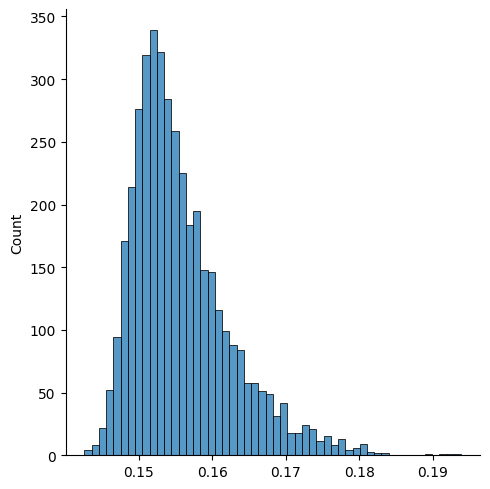

In [13]:
# results_dict["encoded"].mean(dim=0).mean()
import seaborn as sns
sns.displot(results_dict["encoded"].mean(dim=0).numpy())

In [14]:
results_dict["encoded"]

tensor([[0.1567, 0.1752, 0.1537,  ..., 0.1658, 0.1567, 0.1620],
        [0.1374, 0.1577, 0.1376,  ..., 0.1429, 0.1411, 0.1439],
        [0.1885, 0.2030, 0.1731,  ..., 0.1770, 0.1787, 0.1897],
        ...,
        [0.1337, 0.1516, 0.1283,  ..., 0.1344, 0.1339, 0.1370],
        [0.1535, 0.1750, 0.1517,  ..., 0.1636, 0.1556, 0.1578],
        [0.1602, 0.1756, 0.1474,  ..., 0.1518, 0.1513, 0.1613]])

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.heatmap(results_dict["encoded"].cpu().numpy())

In [16]:
# using conch to name each concept ....